In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Set plotting parameters
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['axes.linewidth'] = 0.5
rcParams['xtick.major.width'] = 0.5
rcParams['ytick.major.width'] = 0.5
rcParams['savefig.dpi'] = 300

In [3]:
import os
from catrace.publish_data import read_dataframe_from_h5

publish_data_dir = '../../publish_dataset/Hu_Temiz_et_al_dataset'

dataset_name = 'adult'
# Load behavior measures
behavior_measure_file = os.path.join(publish_data_dir, f'{dataset_name}_dataset/behavior/adult_behavior_measures.h5')
behavior_measure_df = read_dataframe_from_h5(behavior_measure_file)
behavior_measure_df.reset_index('fish_id', inplace=True)
# Select the behavior measure for regression
param_name = 'CombinedZeta'
behavior_measure_name = f'auc_{param_name}_diff_per_day'

In [4]:
behavior_measure_df

,fish_id,auc_CombinedZeta_cs_plus,auc_CombinedZeta_cs_minus,auc_CombinedZeta_diff,auc_CombinedZeta_diff_per_day,auc_CombinedZeta_cs_minus_per_day,auc_CombinedZeta_cs_plus_per_day
0,Extracted_Data_Exp4_Fish3,8.002297,-8.022909,16.025206,2.670868,-1.337152,1.333716
1,Extracted_Data_Exp6_Fish1,8.026830,-7.991074,16.017904,2.669651,-1.331846,1.337805
2,Extracted_Data_Exp6_Fish4,7.514875,-7.398429,14.913304,2.485551,-1.233072,1.252479
3,Extracted_Data_Exp7_Fish3,6.187122,-6.123799,12.310920,2.051820,-1.020633,1.031187
4,Extracted_Data_Exp8_Fish1,2.892981,-2.834808,5.727789,0.954631,-0.472468,0.482164
5,Extracted_Data_Exp8_Fish4,4.463540,-4.517691,8.981230,1.496872,-0.752948,0.743923
6,Extracted_Data_ExpA10_Setup2_Fish1,-5.239593,5.302290,-10.541883,-1.756980,0.883715,-0.873265
7,Extracted_Data_ExpA10_Setup2_Fish2,11.255949,-11.367865,22.623814,3.770636,-1.894644,1.875991
8,Extracted_Data_ExpA10_Setup3_Fish1,29.615710,-29.351313,58.967023,9.827837,-4.891885,4.935952


In [5]:
from analysis_config import adult_window_name_to_frames
#window_name = 'time_window_3s'
# window_name = 'time_window_5s'
# window_name = 'time_window_7s'
window_name = 'time_window_10s'
window = adult_window_name_to_frames[window_name]
print(window_name, window)

fig_dir = f'../figures/{dataset_name}/{window_name}/regression_behavior'
os.makedirs(fig_dir, exist_ok=True)


time_window_10s [40, 115]


In [24]:
from catrace.publish_data import read_distance_results_from_h5
# Load the distance data
window_tag = f'window{window[0]}to{window[1]}'
analysis_results_dir = os.path.join(publish_data_dir, f'{dataset_name}_dataset/analysis_results/{window_name}')
mahal_file = os.path.join(analysis_results_dir, 'mahal_averaged_over_repeats.h5')
center_euclidean_file = os.path.join(analysis_results_dir, 'center_euclidean_averaged_over_repeats.h5')

mahal_df = read_distance_results_from_h5(mahal_file)
center_euclidean_df = read_distance_results_from_h5(center_euclidean_file)

In [25]:
pattern_corr_file = os.path.join(analysis_results_dir, 'pattern_correlation.h5')
cosine_file = os.path.join(analysis_results_dir, 'cosine.h5')

pattern_corr_df = read_distance_results_from_h5(pattern_corr_file)
cosine_df = read_distance_results_from_h5(cosine_file)
    
# Average over trials
pattern_corr_df = pattern_corr_df.groupby(['fish_id', 'condition','odor']).mean().T.groupby('odor').mean().T
cosine_df = cosine_df.groupby(['fish_id', 'condition','odor']).mean().T.groupby('odor').mean().T

In [8]:
from catrace.publish_data import read_distance_results_from_h5
capacity_window = window
cap_analysis_results_dir = os.path.join(publish_data_dir, f'{dataset_name}_dataset/analysis_results/{window_name}')
capacity_file = os.path.join(cap_analysis_results_dir, 'capacity.h5')

capacity_df = read_distance_results_from_h5(capacity_file)

P = 0.506


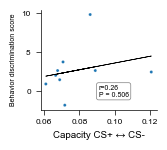

In [9]:
from catrace.run.run_correlate_with_behavior import regression_with_behavior

from catrace.visualize import PlotRegressionParams
plot_regression_params = PlotRegressionParams(
    figsize=(1.8, 1.6),
    marker_size=5,
)

def plot_and_save_corr_with_metric(metric_df, metric, behavior_measure_df, behavior_measure_name, selected_conditions=None, cs_single_direction=1):
    metric_df.reset_index('condition', inplace=True)
    metric_df['condition'] = metric_df['condition'].replace('trained', 'trp-ala')
    metric_df.set_index('condition', inplace=True, append=True)
    # Reorder index levels
    metric_df = metric_df.reorder_levels(['fish_id', 'condition'] + [lvl for lvl in metric_df.index.names if lvl != 'condition' and lvl != 'fish_id'])
    fig, model, text_str = regression_with_behavior(metric_df, metric, behavior_measure_df, behavior_measure_name, cs_single_direction=cs_single_direction, selected_conditions=selected_conditions, plot_regression_params=plot_regression_params)

    ax = fig.get_axes()[0]
    if metric == 'mahal':
        xlabel = 'dM'
        if cs_single_direction == 1:
            cs_tag = 'CS+ → CS-'
        else:
            cs_tag = 'CS- → CS+'
    elif metric == 'center_euclidean':
        xlabel = 'dE'
        cs_tag = 'CS+ ↔ CS-'
    else:
        xlabel = metric.replace('_', ' ').capitalize()
        cs_tag = 'CS+ ↔ CS-'
    ax.set_xlabel(f'{xlabel} {cs_tag}')
    ax.set_ylabel('Behavior discrimination score', fontsize=5)
    # Despine
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Remove legend
    if ax.get_legend() is not None:
        ax.get_legend().remove()

    paper_fig_dir = '/tungstenfs/scratch/gfriedri/hubo/Dp_manifold/figures_for_paper/BNP/behavior'
    os.makedirs(paper_fig_dir, exist_ok=True)
    fig_name = f'behavior_vs_{metric}'
    if cs_single_direction == -1:
        fig_name += 'reversed'
    from catrace.for_paper import save_figure_for_paper
    save_figure_for_paper(fig, fig_name, paper_fig_dir)
    return fig


# fig = plot_and_save_corr_with_metric(center_euclidean_df, 'center_euclidean', behavior_measure_df, behavior_measure_name, cs_single_direction=1)
# fig = plot_and_save_corr_with_metric(mahal_df, 'mahal', behavior_measure_df, behavior_measure_name,  cs_single_direction=1)
# fig = plot_and_save_corr_with_metric(mahal_df, 'mahal', behavior_measure_df, behavior_measure_name, cs_single_direction=-1)
# fig = plot_and_save_corr_with_metric(pattern_corr_df, 'pattern_correlation', behavior_measure_df, behavior_measure_name, cs_single_direction=1)
# fig = plot_and_save_corr_with_metric(cosine_df, 'cosine', behavior_measure_df, behavior_measure_name, cs_single_direction=1)
fig = plot_and_save_corr_with_metric(capacity_df, 'capacity', behavior_measure_df, behavior_measure_name, cs_single_direction=1)